In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples_bal1.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,120,R.G.15.R.A.22.R.G.64.,-_-_-,7.01_31.43_27.35,1,0,0,0,0,...,0,0,0,0,0,0,0,7,3,0
1,1b23.cif1_R,123,R.A.13.R.G.15.R.A.46.,-_-_-,10.88_14.44_12.47,1,0,0,0,0,...,0,0,0,0,0,0,0,5,1,0
2,1b23.cif1_R,111,R.4SU.8.R.A.14.R.A.46.,tWH_t.W_cSS,10.04_12.76_4.86,0,0,1,0,0,...,0,0,0,0,0,0,0,5,1,1
3,1b23.cif1_R,111,R.4SU.8.R.G.15.R.G.48.,-_t.W_cSS,12.32_13.49_4.06,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,1
4,1b23.cif1_R,111,R.A.9.R.A.13.R.A.22.,tHW_tSH_-,11.7_10.01_13.84,0,0,1,1,0,...,0,0,0,0,0,0,0,4,0,1


In [4]:
triplexes.shape

(10700, 477)

In [5]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [6]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


In [7]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 380, '3j79.cif1_A': 282, '3j7p.cif1_S2': 224, '6ha1.cif1_a': 188, '5o5j.cif1_A': 166, '3jam.cif1_2': 149, '5mrc.cif1_aa': 125, '3j9m.cif1_AA': 93, '5oql.cif1_1': 44, '4v9f.cif1_9': 22, '3igi.cif1_A': 20, '4r4v.cif1_A': 19, '3pdr.cif1_X': 18, '5t5h.cif1_D': 18, '4oqu.cif1_A': 16, '1yfg.cif1_A': 15, '4plx.cif1_A': 13, '2qwy.cif1_C': 11, '3u4m.cif1_B': 11, '4mgn.cif1_A': 11, '3v7e.cif1_C': 10, '3wqy.cif1_C': 10, '4prf.cif1_B': 10, '4y1j.cif1_A': 10, '5l4o.cif1_A': 10, '3d0u.cif1_A': 9, '3la5.cif1_A': 9, '3w3s.cif1_B': 9, '4aob.cif1_A': 9, '4jf2.cif1_A': 9, '5mgp.cif1_x': 9, '5oql.cif1_2': 9, '5u3g.cif1_B': 9, '5xxb.cif1_4': 9, '6az3.cif1_3': 9, '3j7q.cif1_8': 8, '4m4o.cif1_B': 8, '4qei.cif1_C': 8, '5b63.cif1_D': 8, '5mmm.cif1_z': 8, '5t5h.cif1_C': 8, '1h3e.cif1_B': 7, '1y26.cif1_X': 7, '3npq.cif1_A': 7, '3q3z.cif1_V': 7, '4m6d.cif1_H': 7, '1s03.cif1_B': 6, '2il9.cif1_A': 6, '2zue.cif1_B': 6, '4jxz.cif1_B': 6, '5ah5.cif1_D': 6, '5kk5.cif1_B': 6, '3dd2.ci

111 aa.U.72.aa.G.202.aa.U.222. cSS_cWW_- 6.11_10.43_10.21 PROBA:  0.4615177011711618
111 aa.A.148.aa.U.223.aa.A.224. -_cWH_cWW 15.88_5.54_12.3 PROBA:  0.4292419006674351
111 aa.U.1033.aa.G.1108.aa.C.1227. cWS_cWW_- 5.59_10.72_9.71 PROBA:  0.4969033290503373
112 aa.G.955.aa.A.972.aa.A.1429. -_-_- 11.01_101.61_96.77 PROBA:  0.5057328250182541
112 aa.G.117.aa.A.1171.aa.U.1180. -_cWW_- 140.38_10.47_137.19 PROBA:  0.599116338532531
112 aa.C.61.aa.G.361.aa.A.393. cWW_-_- 10.59_20.41_25.08 PROBA:  0.6552637732374293
110 aa.C.59.aa.A.235.aa.G.363. -_-_cWW 39.48_46.79_10.81 PROBA:  0.5446462220046007
CONFUSION MATRIX By chain:  5mrc.cif1_aa
[[61  4]
 [ 3 57]]

CONFUSION MATRIX By chain:  4zdo.cif1_E
[[2 0]
 [0 1]]

123 X.A.71.X.A.72.X.U.167. -_-_- 4.99_16.51_13.15 PROBA:  0.506067938693552
111 X.G.22.X.A.71.X.C.163. tSS_-_cWW 7.83_5.61_10.72 PROBA:  0.393007626477556
111 X.C.33.X.A.88.X.G.151. -_tSS_cWW 5.95_7.94_10.45 PROBA:  0.4187346437266138
111 X.A.101.X.A.103.X.U.167. -_cWS_cHW 8.88_9.43_

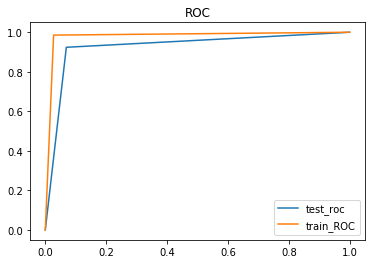

Probability density for train


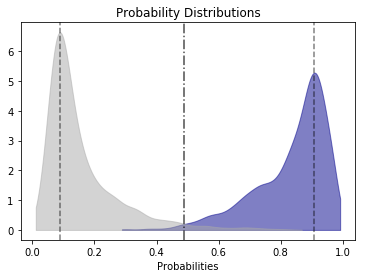

Probability density for test


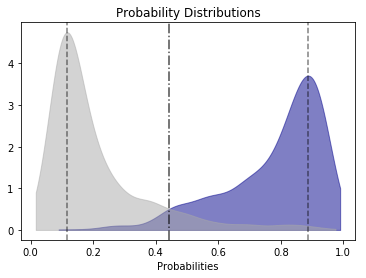


[[1050   78]
 [  77  935]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1050    78  1128
1            77   935  1012
All        1127  1013  2140


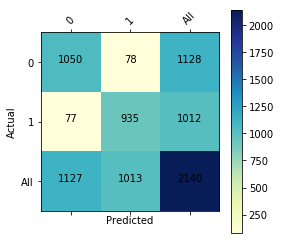


REPORT
             precision    recall  f1-score   support

          0       0.93      0.93      0.93      1128
          1       0.92      0.92      0.92      1012

avg / total       0.93      0.93      0.93      2140

ACCURACY =  0.927570093457944
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 333, '4ioa.cif1_X': 285, '5mrc.cif1_A': 239, '5xy3.cif1_1': 223, '6ek0.cif1_S2': 163, '3j7a.cif1_A': 142, '5ngm.cif1_Aa': 137, '5t5h.cif1_B': 82, '5t2a.cif1_B': 77, '5ml7.cif1_B': 20, '5j7l.cif1_DB': 19, '5xy3.cif1_3': 18, '6d90.cif1_4': 17, '1c0a.cif1_B': 15, '5xxb.cif1_3': 14, '5ccb.cif1_N': 12, '2r8s.cif1_R': 11, '4wj4.cif1_B': 11, '1j1u.cif1_B': 10, '3f2x.cif1_X': 10, '3j79.cif1_C': 10, '4pr6.cif1_B': 10, '4uyk.cif1_R': 10, '5tbw.cif1_4': 10, '2azx.cif1_D': 9, '2d6f.cif1_F': 9, '2xdb.cif1_G': 9, '3al0.cif1_E': 9, '3kfu.cif1_L': 9, '3ski.cif1_A': 9, '4mgn.cif1_B': 9, '4qk9.cif1_A': 9, '5wwt.cif1_C': 9, '6cb3.cif1_B': 9, '1n78.cif1_C': 8, '4fen.cif1_B': 8, '4tue.cif1_QV': 8, '4znp.c

123 B.G.39.B.A.42.B.U.43. -_-_- 8.81_4.71_12.53 PROBA:  0.8574306318747231
CONFUSION MATRIX By chain:  1mzp.cif1_B
[[2 1]
 [0 3]]

CONFUSION MATRIX By chain:  4kzd.cif1_R
[[3 0]
 [0 1]]

111 B.U.46.B.A2M.50.B.G.464. tSH_cWS_- 9.29_10.21_10.13 PROBA:  0.4227574048654625
111 B.G.880.B.C.909.B.U.1142. cWW_-_cSW 10.31_10.91_8.85 PROBA:  0.31612024415662976
110 B.5MC.624.B.A.1528.B.U.1544. -_cWW_- 22.44_9.85_15.52 PROBA:  0.5930462534313695
CONFUSION MATRIX By chain:  5t5h.cif1_B
[[40  1]
 [ 2 39]]

CONFUSION MATRIX By chain:  2d6f.cif1_F
[[5 0]
 [0 4]]

110 B.G.17.B.G.20.B.A.21. -_-_- 7.15_6.96_4.79 PROBA:  0.8271728156999224
CONFUSION MATRIX By chain:  5xtm.cif1_B
[[2 1]
 [0 2]]

111 A.C.15.A.G.19.A.A.39. cWW_t.W_cSW 10.7_12.97_5.54 PROBA:  0.40913640793532857
CONFUSION MATRIX By chain:  4oji.cif1_A
[[5 0]
 [1 1]]

CONFUSION MATRIX By chain:  1f7u.cif1_B
[[4 0]
 [0 2]]

CONFUSION MATRIX By chain:  3al0.cif1_E
[[5 0]
 [0 4]]

CONFUSION MATRIX By chain:  4uyk.cif1_R
[[5 0]
 [0 5]]

CONFUSIO

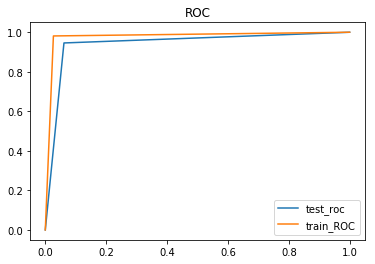

Probability density for train


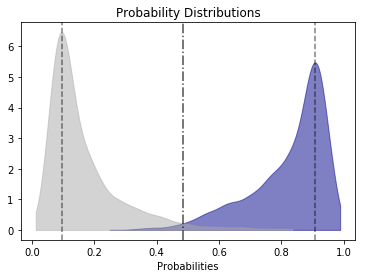

Probability density for test


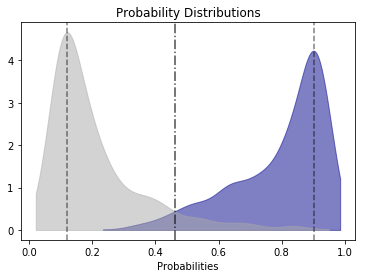


[[1056   69]
 [  55  960]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1056    69  1125
1            55   960  1015
All        1111  1029  2140


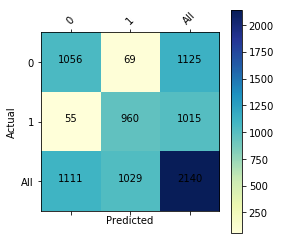


REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.94      1125
          1       0.93      0.95      0.94      1015

avg / total       0.94      0.94      0.94      2140

ACCURACY =  0.9420560747663551
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 321, '6eri.cif1_AA': 295, '5xxb.cif1_1': 247, '6d9j.cif1_5': 210, '6az1.cif1_1': 173, '5xxu.cif1_2': 139, '5xyi.cif1_2': 127, '5t5h.cif1_A': 103, '1u6b.cif1_B': 27, '1u9s.cif1_A': 23, '2a64.cif1_A': 20, '6az3.cif1_8': 20, '6ha1.cif1_B': 19, '4ycp.cif1_B': 18, '4wf9.cif1_Y': 17, '5lys.cif1_B': 15, '5fjc.cif1_A': 13, '5tbw.cif1_AS': 12, '5e6m.cif1_C': 11, '6d9j.cif1_7': 11, '4lck.cif1_F': 10, '4rdx.cif1_C': 10, '5hr6.cif1_C': 10, '5hr7.cif1_D': 10, '6d9j.cif1_8': 10, '6gaz.cif1_AV': 10, '1ser.cif1_T': 9, '2gdi.cif1_X': 9, '4jrc.cif1_B': 9, '4rzd.cif1_A': 9, '5aj0.cif1_Bv': 9, '5mrc.cif1_bb': 9, '5zwn.cif1_P': 9, '6cfj.cif1_1x': 9, '6ek0.cif1_S6': 9, '1il2.cif1_C': 8, '1qu2.cif1_T': 8,

CONFUSION MATRIX By chain:  2xd0.cif1_W
[[3 0]
 [0 4]]

CONFUSION MATRIX By chain:  5lzs.cif1_3
[[5 0]
 [0 3]]

111 1.U.78.1.U.107.1.G.333. -_cSS_tWW 11.27_4.34_11.4 PROBA:  0.42532295647891943
111 1.U.866.1.U.2830.1.C.2848. cHW_-_cWW 8.66_13.75_7.82 PROBA:  0.4260237066169005
111 1.A.2327.1.G.2542.1.C.2711. tWS_cWW_- 8.31_10.84_7.43 PROBA:  0.46290011900473566
111 1.A.2346.1.C.2540.1.G.2713. -_cWW_tSS 7.04_10.7_8.16 PROBA:  0.3514400950651291
111 1.U.2933.1.U.2979.1.A.3052. c.W_-_cSS 11.39_13.88_5.2 PROBA:  0.4051022452111277
112 1.G.2509.1.A.2930.1.C.3095. -_-_cWW 30.3_38.63_10.97 PROBA:  0.5434471223137366
112 1.U.278.1.C.3137.1.G.3142. -_cWW_- 149.98_11.18_144.28 PROBA:  0.5392454393968309
110 1.A.1264.1.G.3029.1.C.3039. -_cWW_- 69.82_10.8_71.79 PROBA:  0.5725920004871239
CONFUSION MATRIX By chain:  5xxb.cif1_1
[[123   3]
 [  5 116]]

CONFUSION MATRIX By chain:  2gdi.cif1_X
[[5 0]
 [0 4]]

110 C.G.59.C.G.63.C.C.96. -_-_cWW 18.97_15.47_11.26 PROBA:  0.7402007064996965
CONFUSION MATR

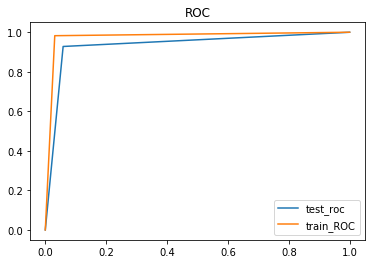

Probability density for train


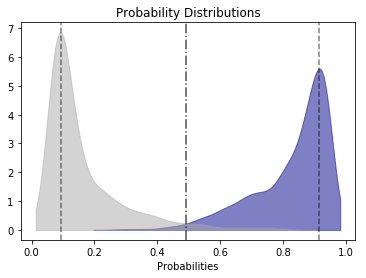

Probability density for test


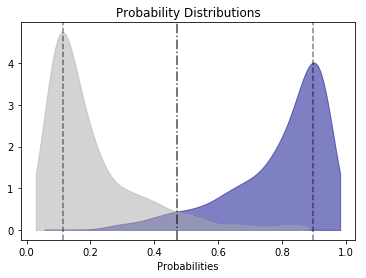


[[1060   66]
 [  73  941]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1060    66  1126
1            73   941  1014
All        1133  1007  2140


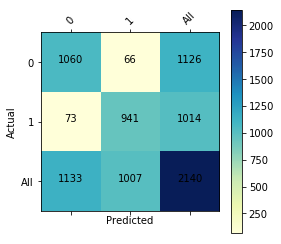


REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94      1126
          1       0.93      0.93      0.93      1014

avg / total       0.94      0.94      0.94      2140

ACCURACY =  0.9350467289719626
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 318, '6ha1.cif1_A': 297, '5tbw.cif1_1': 272, '5j7l.cif1_AA': 186, '5ool.cif1_A': 166, '6gaw.cif1_BA': 160, '6az3.cif1_1': 116, '6az3.cif1_2': 82, '6gaz.cif1_AA': 82, '4ioa.cif1_Y': 20, '4gxy.cif1_A': 19, '4kqy.cif1_A': 18, '4yaz.cif1_R': 18, '6ek0.cif1_L7': 15, '4qk8.cif1_A': 14, '3hhn.cif1_E': 13, '2der.cif1_D': 11, '5t83.cif1_A': 11, '1h4s.cif1_T': 10, '2qus.cif1_A': 10, '3dil.cif1_A': 10, '4p5j.cif1_A': 10, '4v8n.cif1_CV': 10, '6gaw.cif1_BB': 10, '1i6u.cif1_C': 9, '1u0b.cif1_A': 9, '4gcw.cif1_B': 9, '4v9k.cif1_AW': 9, '4yye.cif1_C': 9, '5aox.cif1_C': 9, '5e81.cif1_2K': 9, '6az3.cif1_7': 9, '6ck5.cif1_A': 9, '3amu.cif1_B': 8, '3oxe.cif1_A': 8, '4y1m.cif1_B': 8, '5jup.cif1_EC': 8, 

[[58  1]
 [ 5 52]]

112 2.U.8.2.G.10.2.G.45. -_cHS_- 13.5_8.85_13.51 PROBA:  0.5372998331263303
CONFUSION MATRIX By chain:  5lzs.cif1_2
[[2 1]
 [0 2]]

0 BB.C.33.BB.U.34.BB.G.41. -_-_- 6.45_14.0_8.34 PROBA:  0.5057049099570837
123 BB.U.8.BB.A.9.BB.A.24. -_-_- 8.25_12.23_11.53 PROBA:  0.5074057503723479
CONFUSION MATRIX By chain:  6gaw.cif1_BB
[[4 2]
 [0 4]]

111 A.A.65.A.U.89.A.C.503. cWW_-_cSW 10.51_11.02_7.81 PROBA:  0.4461472875209872
111 A.A.194.A.A.207.A.G.846. tHH_-_tSS 10.88_11.83_8.17 PROBA:  0.33361714061020314
111 A.C.588.A.G.595.A.A.1260. cWW_cSW_- 10.66_6.16_12.11 PROBA:  0.4808585706906404
111 A.C.1118.A.G.1139.A.A.1144. t.W_tSH_- 9.57_10.01_11.43 PROBA:  0.4775372814672682
111 A.A.1831.A.A.1844.A.G.2232. tWH_cWW_- 11.52_12.02_12.44 PROBA:  0.289579506137012
111 A.A.1832.A.G.1843.A.G.2232. tHS_tWW_- 9.64_13.36_16.28 PROBA:  0.3195461504971801
111 A.C.2277.A.G.2284.A.C.2304. -_cWW_cWH 13.57_10.53_8.79 PROBA:  0.20677536709886715
112 A.C.1402.A.G.1407.A.A.1661. cWW_-_- 10.77

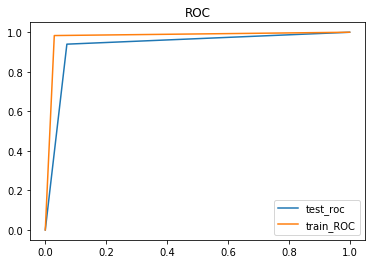

Probability density for train


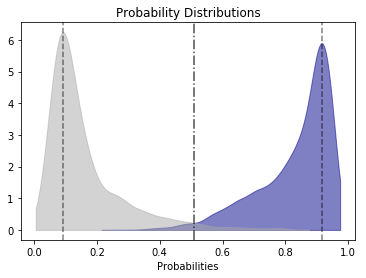

Probability density for test


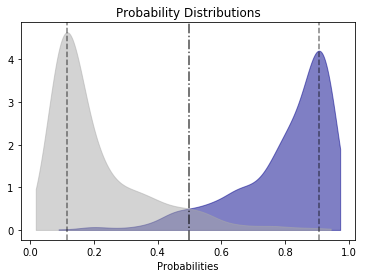


[[1048   80]
 [  61  951]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1048    80  1128
1            61   951  1012
All        1109  1031  2140


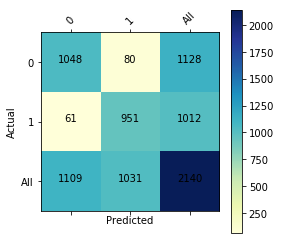


REPORT
             precision    recall  f1-score   support

          0       0.94      0.93      0.94      1128
          1       0.92      0.94      0.93      1012

avg / total       0.93      0.93      0.93      2140

ACCURACY =  0.9341121495327103
-----------------
TEST_GROUPS Counter({'5o60.cif1_A': 299, '6ek0.cif1_L5': 298, '4wf9.cif1_X': 273, '4v88.cif1_A6': 188, '4lfb.cif1_A': 174, '6eri.cif1_BA': 160, '5an9.cif1_N': 119, '6d9j.cif1_2': 115, '4p95.cif1_A': 25, '1nbs.cif1_B': 21, '3j7o.cif1_7': 20, '3j79.cif1_B': 19, '5fdv.cif1_1B': 19, '5xym.cif1_B': 18, '6eri.cif1_Ax': 16, '3mxh.cif1_R': 14, '3ivk.cif1_M': 13, '1mfq.cif1_A': 11, '4yco.cif1_D': 11, '5wt1.cif1_C': 11, '1qtq.cif1_B': 10, '3ndb.cif1_M': 10, '4qlm.cif1_A': 10, '5axm.cif1_P': 10, '6az3.cif1_5': 10, '6eri.cif1_AB': 10, '1evv.cif1_A': 9, '1y27.cif1_X': 9, '3eph.cif1_E': 9, '3iwn.cif1_A': 9, '3skl.cif1_B': 9, '4lx6.cif1_A': 9, '5ool.cif1_B': 9, '5xy3.cif1_4': 9, '6az3.cif1_4': 9, '2du3.cif1_D': 8, '3ivn.cif1_A': 8, '

111 1L.U.8.1L.A.14.1L.U.59. tWH_tWW_- 9.5_9.85_6.15 PROBA:  0.34231831255821293
100 1L.A.14.1L.C.30.1L.G.42. -_-_- 32.23_8.31_24.79 PROBA:  0.5552115608798339
CONFUSION MATRIX By chain:  5ibb.cif1_1L
[[1 1]
 [1 0]]

111 A.G.6.A.C.261.A.A.557. cWW_-_cH. 10.81_15.03_13.22 PROBA:  0.40158340753684835
111 A.U.8.A.A.259.A.A.556. -_cSW_tWH 8.61_9.14_9.35 PROBA:  0.4404046972686897
100 A.A.248.A.A.268.A.A.275. -_-_- 41.7_26.51_47.0 PROBA:  0.519202206545747
CONFUSION MATRIX By chain:  4p95.cif1_A
[[12  1]
 [ 2 10]]

CONFUSION MATRIX By chain:  5d8h.cif1_A
[[4 0]
 [0 4]]

CONFUSION MATRIX By chain:  4yco.cif1_D
[[6 0]
 [0 5]]

110 E.U.125.E.U.135.E.C.137. -_cSH_- 37.31_8.21_33.64 PROBA:  0.5469515942985398
CONFUSION MATRIX By chain:  1e8o.cif1_E
[[0 1]
 [0 1]]

111 B.U.147.B.A.160.B.A.206. tWH_tWW_- 9.76_13.81_9.84 PROBA:  0.47174220084085255
111 B.U.147.B.G.205.B.A.207. -_tSH_cSS 11.45_7.49_5.73 PROBA:  0.4136636063901122
110 B.C.146.B.U.153.B.G.162. -_-_cWW 22.99_21.67_10.92 PROBA:  0.542309

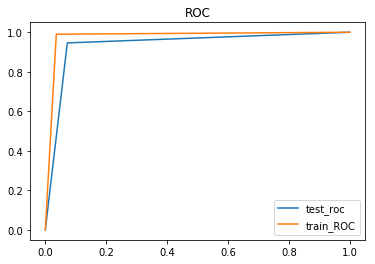

Probability density for train


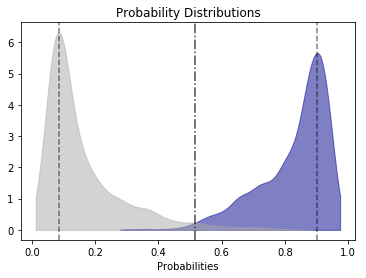

Probability density for test


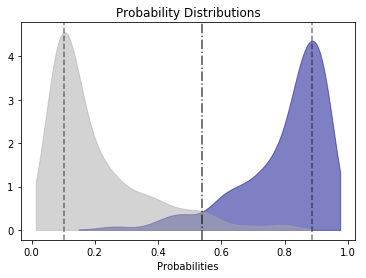


[[1038   81]
 [  55  966]]
CONFUSION MATRIX
Predicted     0     1   All
Actual                     
0          1038    81  1119
1            55   966  1021
All        1093  1047  2140


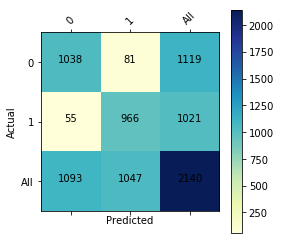


REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94      1119
          1       0.92      0.95      0.93      1021

avg / total       0.94      0.94      0.94      2140

ACCURACY =  0.9364485981308411
-----------------


In [8]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row['type'], row['dssrs'], row['bps'], row['dists'], "PROBA: ", predict_proba_by_chain[i][1])
            i = i + 1

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9777647686485522

AUC =  0.943176086530109


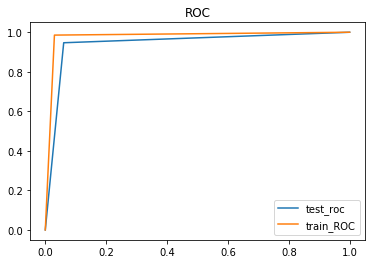

Probability density for train


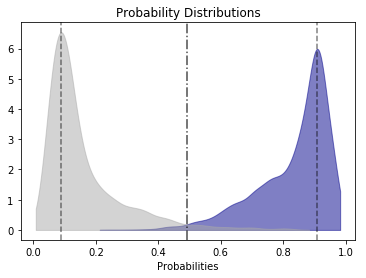

Probability density for test


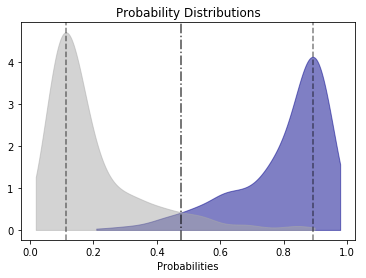


[[528  34]
 [ 27 481]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          528   34   562
1           27  481   508
All        555  515  1070


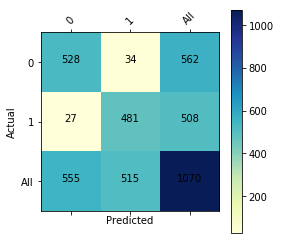

REPORT
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       562
          1       0.93      0.95      0.94       508

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9429906542056075
-----------------

AUC_TRAIN =  0.9756230928339107

AUC =  0.9271333130352312


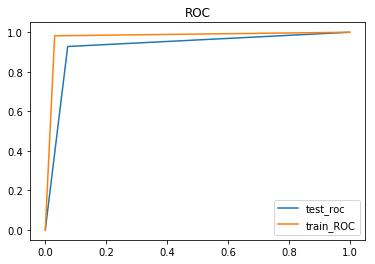

Probability density for train


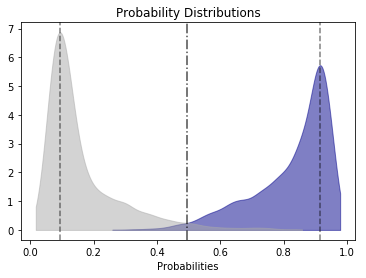

Probability density for test


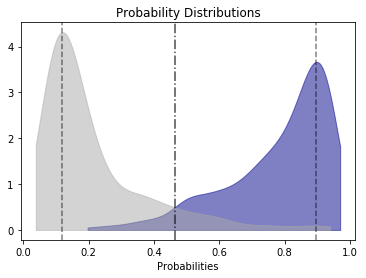


[[516  41]
 [ 37 476]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          516   41   557
1           37  476   513
All        553  517  1070


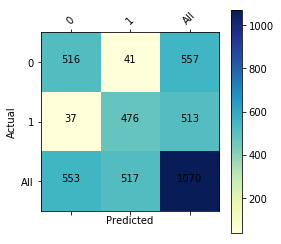

REPORT
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       557
          1       0.92      0.93      0.92       513

avg / total       0.93      0.93      0.93      1070

ACCURACY 0.9271028037383178
-----------------

AUC_TRAIN =  0.9745627312642621

AUC =  0.9482344694646455


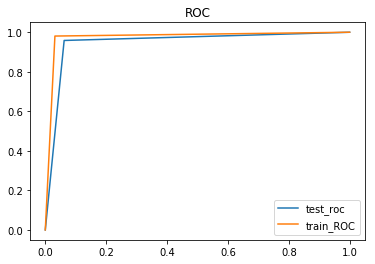

Probability density for train


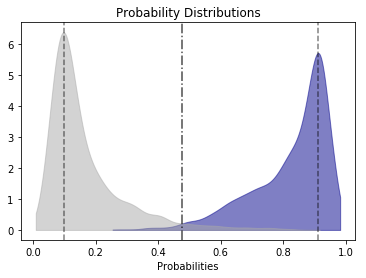

Probability density for test


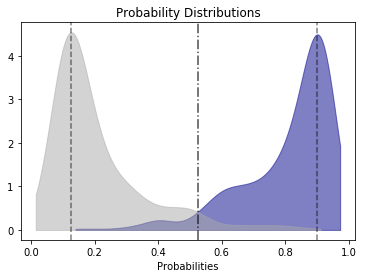


[[530  35]
 [ 21 484]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          530   35   565
1           21  484   505
All        551  519  1070


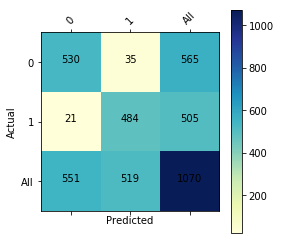

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       565
          1       0.93      0.96      0.95       505

avg / total       0.95      0.95      0.95      1070

ACCURACY 0.9476635514018692
-----------------

AUC_TRAIN =  0.9764827851745035

AUC =  0.9460477577902839


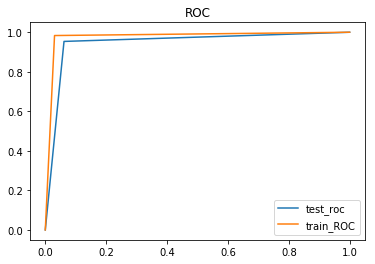

Probability density for train


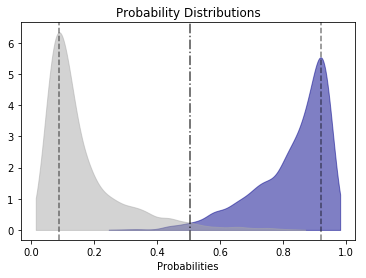

Probability density for test


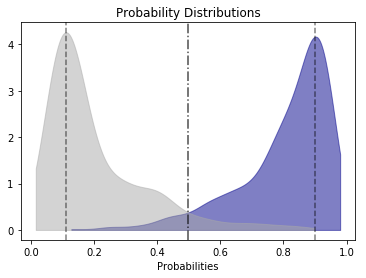


[[519  34]
 [ 24 493]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          519   34   553
1           24  493   517
All        543  527  1070


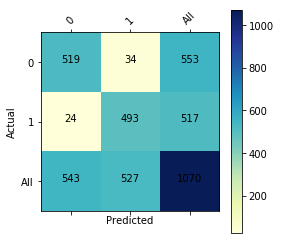

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       553
          1       0.94      0.95      0.94       517

avg / total       0.95      0.95      0.95      1070

ACCURACY 0.9457943925233645
-----------------

AUC_TRAIN =  0.9775949437869159

AUC =  0.9425041619206168


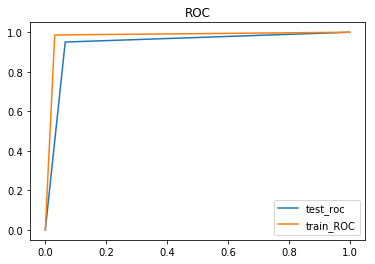

Probability density for train


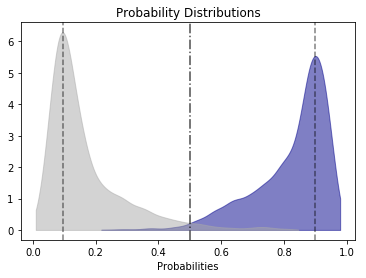

Probability density for test


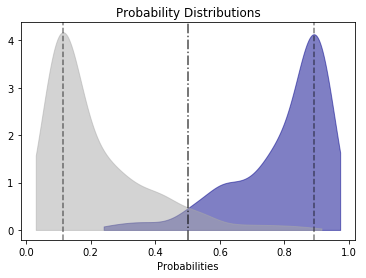


[[528  37]
 [ 25 480]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          528   37   565
1           25  480   505
All        553  517  1070


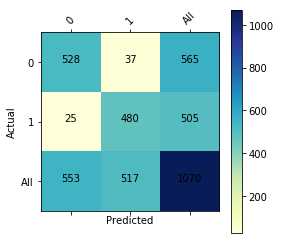

REPORT
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       565
          1       0.93      0.95      0.94       505

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9420560747663551
-----------------

AUC_TRAIN =  0.9763080489428421

AUC =  0.9265044652718609


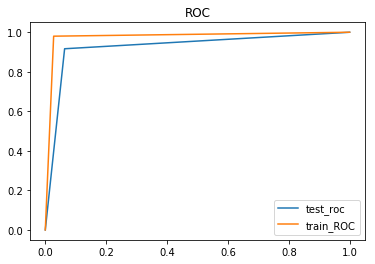

Probability density for train


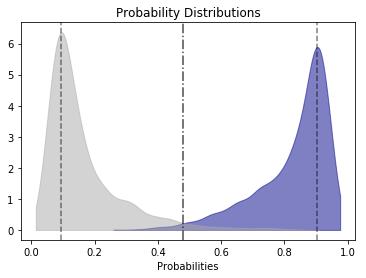

Probability density for test


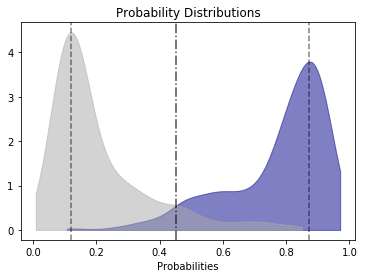


[[531  36]
 [ 42 461]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          531   36   567
1           42  461   503
All        573  497  1070


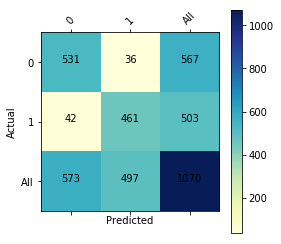

REPORT
             precision    recall  f1-score   support

          0       0.93      0.94      0.93       567
          1       0.93      0.92      0.92       503

avg / total       0.93      0.93      0.93      1070

ACCURACY 0.9271028037383178
-----------------

AUC_TRAIN =  0.9774980323643628

AUC =  0.943844999719558


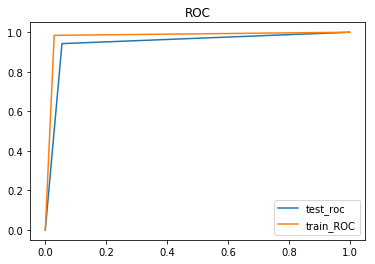

Probability density for train


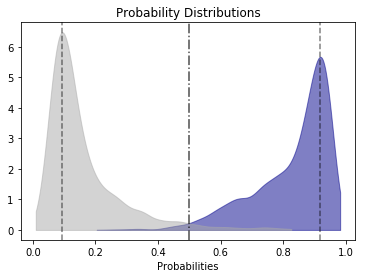

Probability density for test


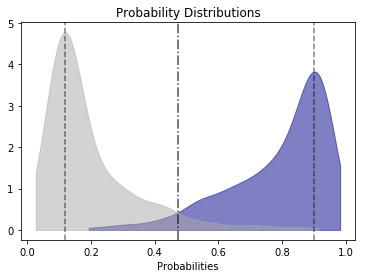


[[535  31]
 [ 29 475]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          535   31   566
1           29  475   504
All        564  506  1070


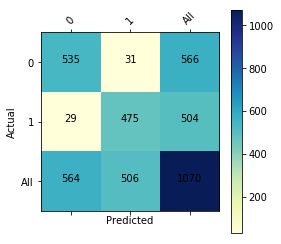

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       566
          1       0.94      0.94      0.94       504

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9439252336448598
-----------------

AUC_TRAIN =  0.9777097600234852

AUC =  0.9456402549038156


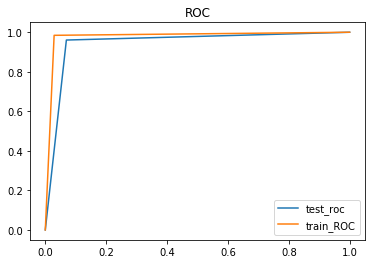

Probability density for train


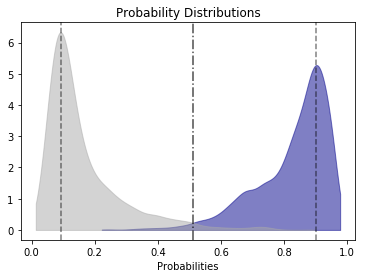

Probability density for test


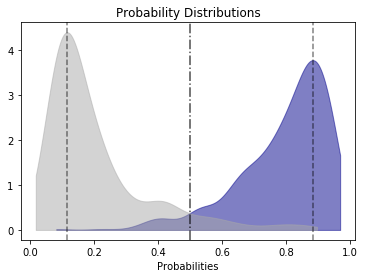


[[524  39]
 [ 20 487]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          524   39   563
1           20  487   507
All        544  526  1070


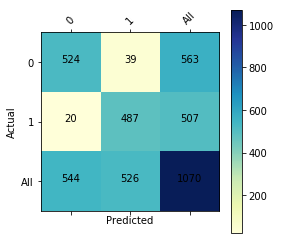

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       563
          1       0.93      0.96      0.94       507

avg / total       0.95      0.94      0.94      1070

ACCURACY 0.9448598130841122
-----------------

AUC_TRAIN =  0.976173091874001

AUC =  0.9405845602292778


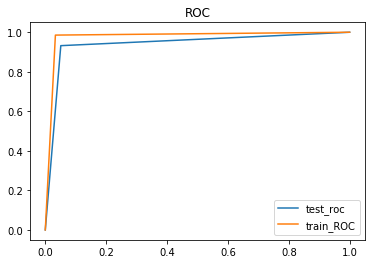

Probability density for train


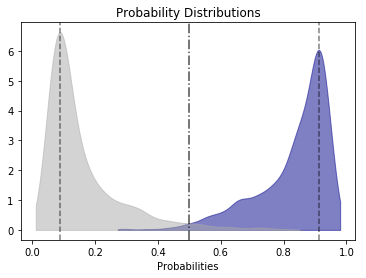

Probability density for test


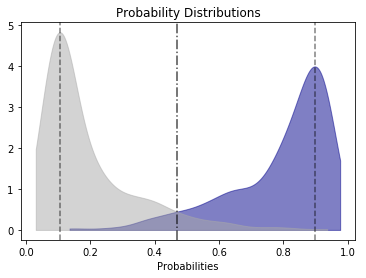


[[540  29]
 [ 34 467]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          540   29   569
1           34  467   501
All        574  496  1070


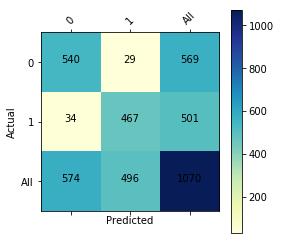

REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       569
          1       0.94      0.93      0.94       501

avg / total       0.94      0.94      0.94      1070

ACCURACY 0.9411214953271028
-----------------

AUC_TRAIN =  0.9761040323958755

AUC =  0.9497670217644731


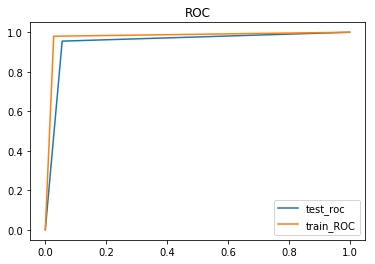

Probability density for train


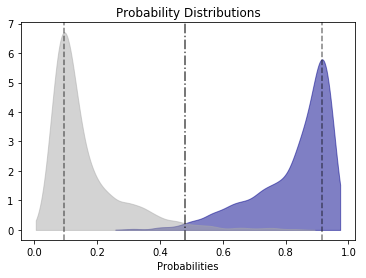

Probability density for test


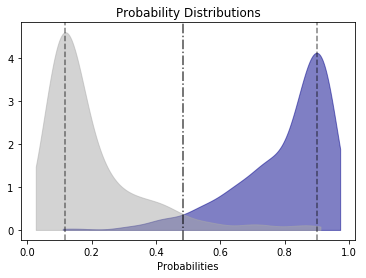


[[528  31]
 [ 23 488]]
CONFUSION MATRIX
Predicted    0    1   All
Actual                   
0          528   31   559
1           23  488   511
All        551  519  1070


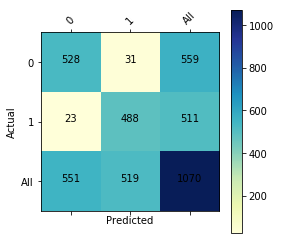

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       559
          1       0.94      0.95      0.95       511

avg / total       0.95      0.95      0.95      1070

ACCURACY 0.9495327102803738
-----------------


In [9]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")



AUC_TRAIN =  0.9763182420203256

AUC =  0.935318767542239


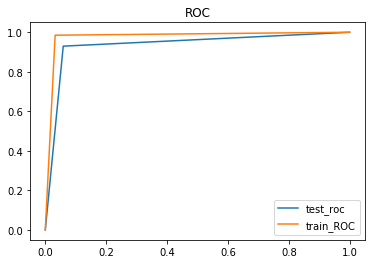

Probability density for train


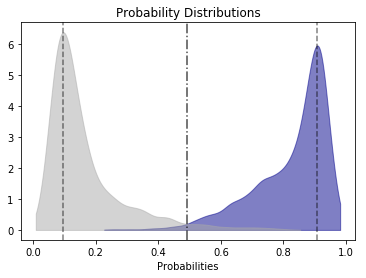

Probability density for test


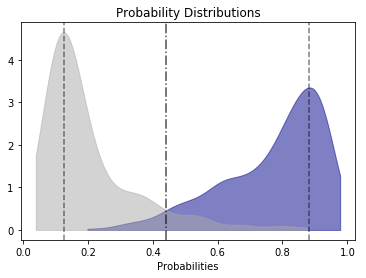


[[351  22]
 [ 24 317]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          351   22  373
1           24  317  341
All        375  339  714


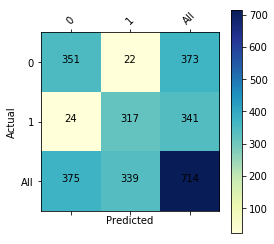

REPORT
             precision    recall  f1-score   support

          0       0.94      0.94      0.94       373
          1       0.94      0.93      0.93       341

avg / total       0.94      0.94      0.94       714

ACCURACY 0.9355742296918768
-----------------

AUC_TRAIN =  0.9772344866377339

AUC =  0.9466430678466077


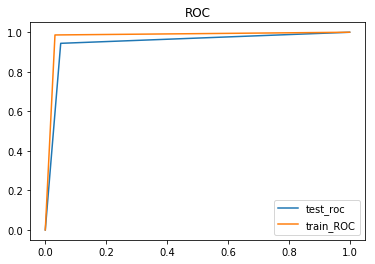

Probability density for train


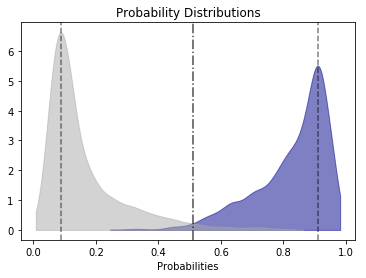

Probability density for test


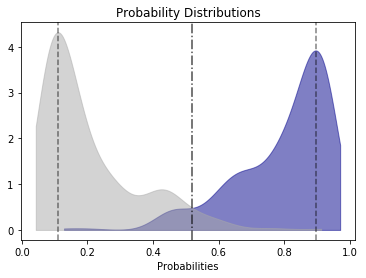


[[356  19]
 [ 19 320]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          356   19  375
1           19  320  339
All        375  339  714


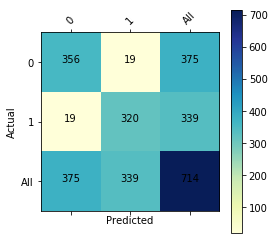

REPORT
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       375
          1       0.94      0.94      0.94       339

avg / total       0.95      0.95      0.95       714

ACCURACY 0.9467787114845938
-----------------

AUC_TRAIN =  0.9749538288288289

AUC =  0.9512149062067228


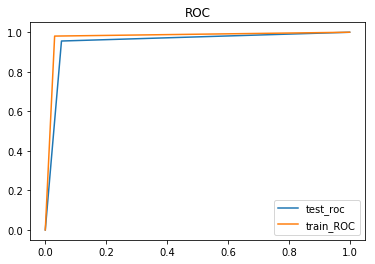

Probability density for train


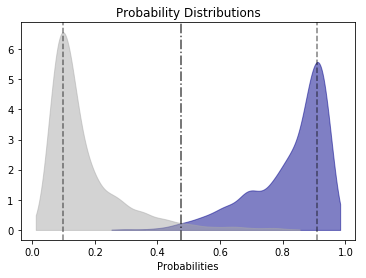

Probability density for test


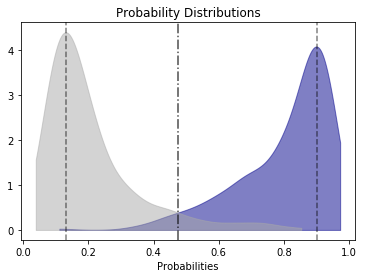


[[356  20]
 [ 15 323]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          356   20  376
1           15  323  338
All        371  343  714


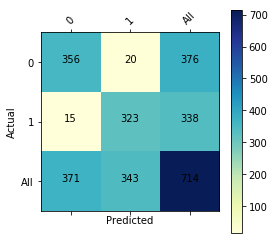

REPORT
             precision    recall  f1-score   support

          0       0.96      0.95      0.95       376
          1       0.94      0.96      0.95       338

avg / total       0.95      0.95      0.95       714

ACCURACY 0.9509803921568627
-----------------

AUC_TRAIN =  0.9759007779965948

AUC =  0.9260938053794352


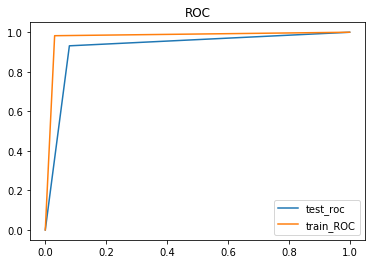

Probability density for train


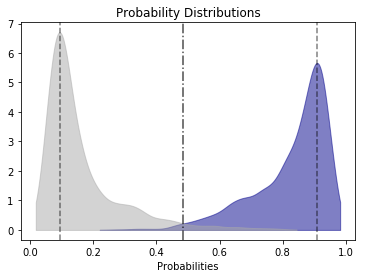

Probability density for test


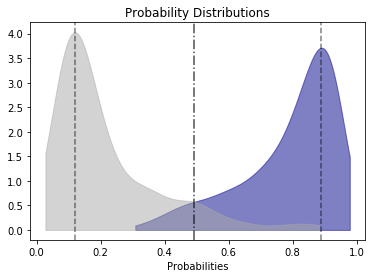


[[349  30]
 [ 23 312]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   30  379
1           23  312  335
All        372  342  714


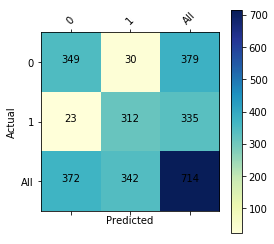

REPORT
             precision    recall  f1-score   support

          0       0.94      0.92      0.93       379
          1       0.91      0.93      0.92       335

avg / total       0.93      0.93      0.93       714

ACCURACY 0.9257703081232493
-----------------

AUC_TRAIN =  0.9753699780888531

AUC =  0.9420932081322955


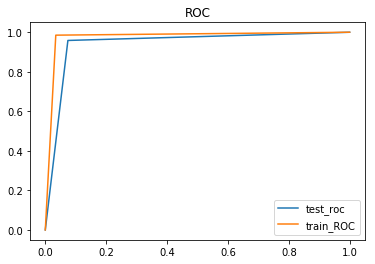

Probability density for train


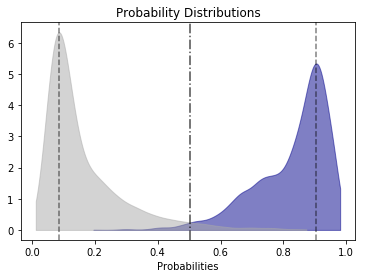

Probability density for test


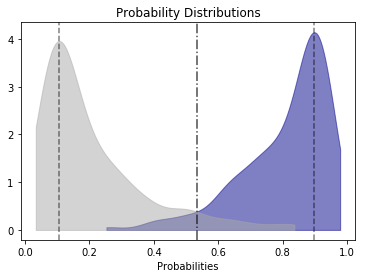


[[349  28]
 [ 14 323]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   28  377
1           14  323  337
All        363  351  714


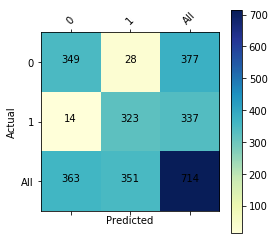

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.94       377
          1       0.92      0.96      0.94       337

avg / total       0.94      0.94      0.94       714

ACCURACY 0.9411764705882353
-----------------

AUC_TRAIN =  0.9772463046773785

AUC =  0.9408514492753624


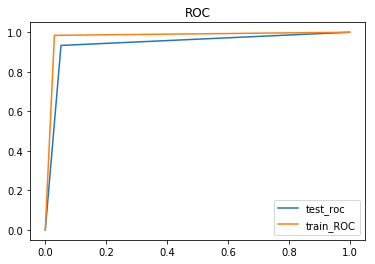

Probability density for train


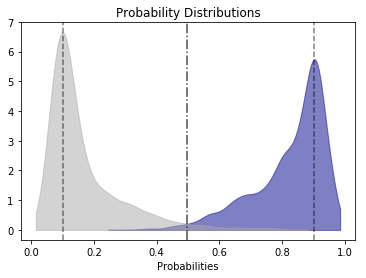

Probability density for test


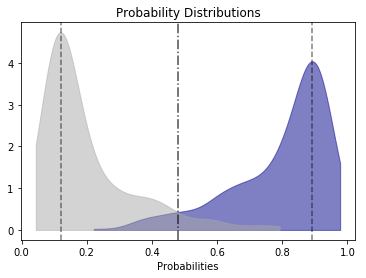


[[349  19]
 [ 23 322]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   19  368
1           23  322  345
All        372  341  713


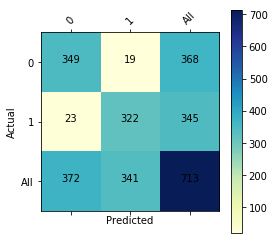

REPORT
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       368
          1       0.94      0.93      0.94       345

avg / total       0.94      0.94      0.94       713

ACCURACY 0.94109396914446
-----------------

AUC_TRAIN =  0.9774224192526916

AUC =  0.9539625292000758


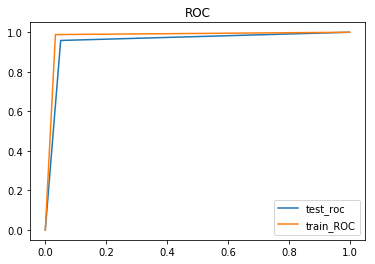

Probability density for train


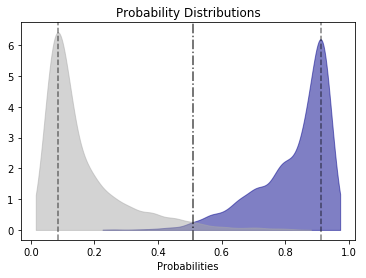

Probability density for test


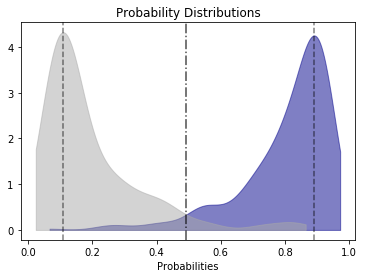


[[357  19]
 [ 14 323]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          357   19  376
1           14  323  337
All        371  342  713


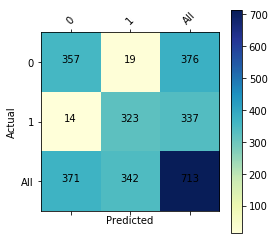

REPORT
             precision    recall  f1-score   support

          0       0.96      0.95      0.96       376
          1       0.94      0.96      0.95       337

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9537166900420757
-----------------

AUC_TRAIN =  0.9763688955473049

AUC =  0.9379670737680312


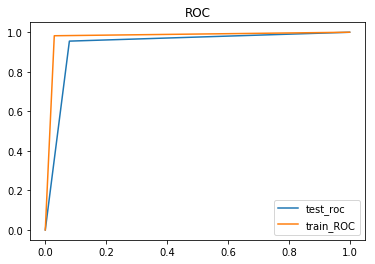

Probability density for train


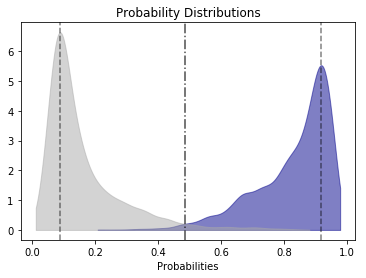

Probability density for test


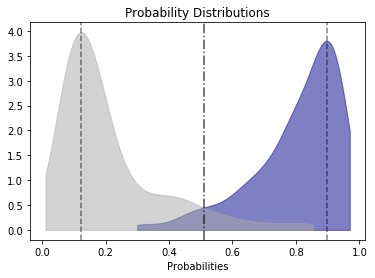


[[349  30]
 [ 15 319]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          349   30  379
1           15  319  334
All        364  349  713


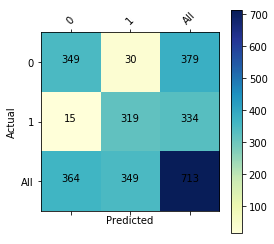

REPORT
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       379
          1       0.91      0.96      0.93       334

avg / total       0.94      0.94      0.94       713

ACCURACY 0.9368863955119214
-----------------

AUC_TRAIN =  0.9782937098210379

AUC =  0.9292465483234715


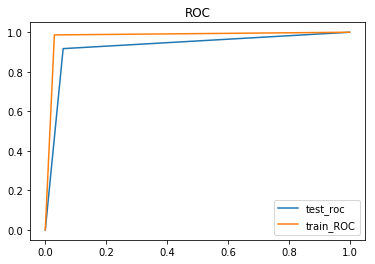

Probability density for train


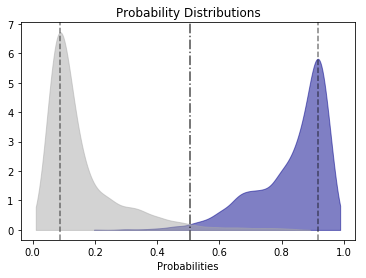

Probability density for test


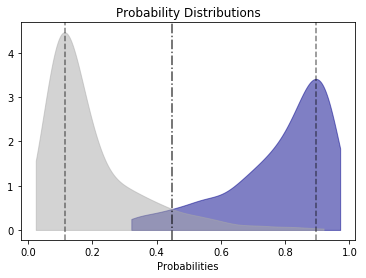


[[353  22]
 [ 28 310]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          353   22  375
1           28  310  338
All        381  332  713


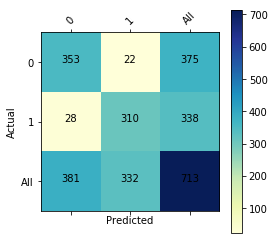

REPORT
             precision    recall  f1-score   support

          0       0.93      0.94      0.93       375
          1       0.93      0.92      0.93       338

avg / total       0.93      0.93      0.93       713

ACCURACY 0.9298737727910238
-----------------

AUC_TRAIN =  0.9750201755179589

AUC =  0.9524788496748532


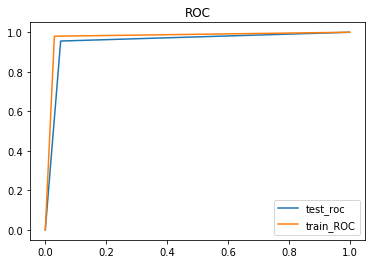

Probability density for train


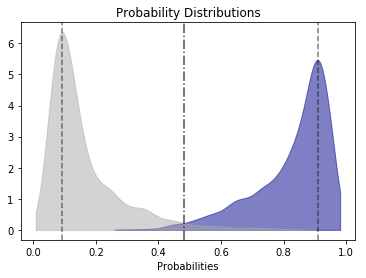

Probability density for test


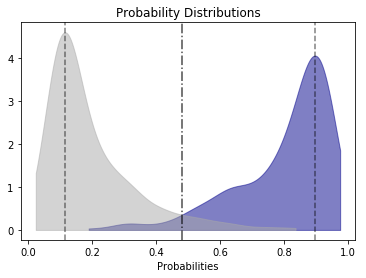


[[357  19]
 [ 15 322]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          357   19  376
1           15  322  337
All        372  341  713


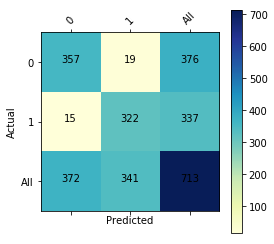

REPORT
             precision    recall  f1-score   support

          0       0.96      0.95      0.95       376
          1       0.94      0.96      0.95       337

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9523141654978962
-----------------

AUC_TRAIN =  0.9775008870575489

AUC =  0.9502485207100592


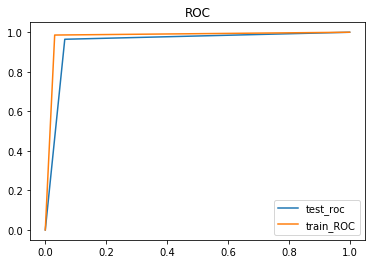

Probability density for train


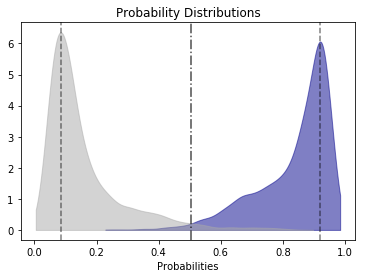

Probability density for test


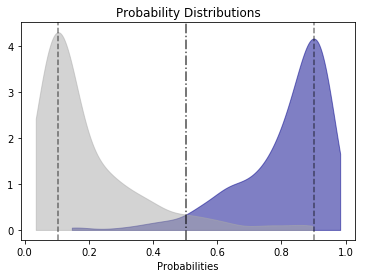


[[351  24]
 [ 12 326]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          351   24  375
1           12  326  338
All        363  350  713


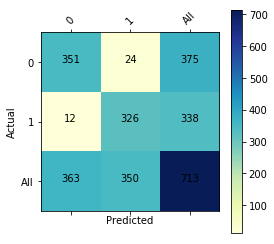

REPORT
             precision    recall  f1-score   support

          0       0.97      0.94      0.95       375
          1       0.93      0.96      0.95       338

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9495091164095372
-----------------

AUC_TRAIN =  0.9758285238126071

AUC =  0.9472293124094032


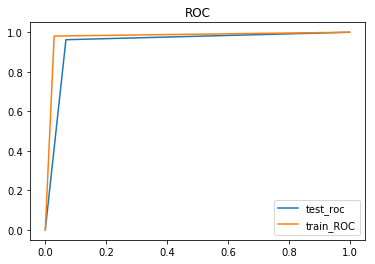

Probability density for train


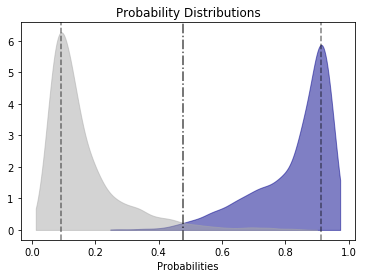

Probability density for test


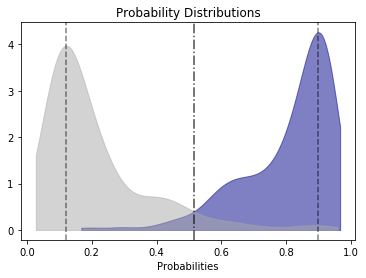


[[344  25]
 [ 13 331]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          344   25  369
1           13  331  344
All        357  356  713


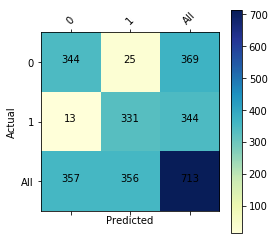

REPORT
             precision    recall  f1-score   support

          0       0.96      0.93      0.95       369
          1       0.93      0.96      0.95       344

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9467040673211781
-----------------

AUC_TRAIN =  0.9778013596678512

AUC =  0.9457048962760496


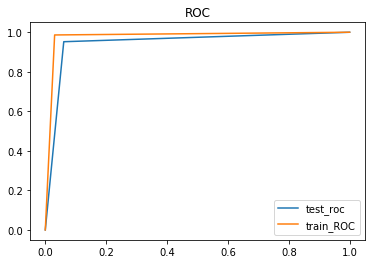

Probability density for train


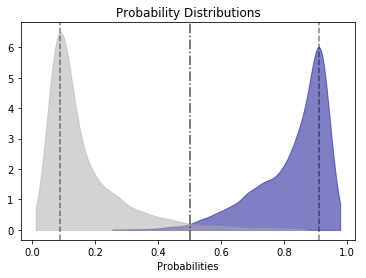

Probability density for test


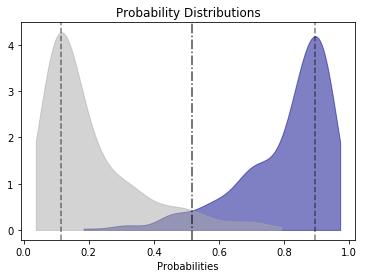


[[356  23]
 [ 16 318]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          356   23  379
1           16  318  334
All        372  341  713


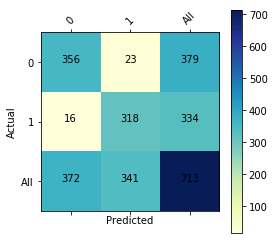

REPORT
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       379
          1       0.93      0.95      0.94       334

avg / total       0.95      0.95      0.95       713

ACCURACY 0.9453015427769986
-----------------

AUC_TRAIN =  0.9767039079635141

AUC =  0.9241381756277485


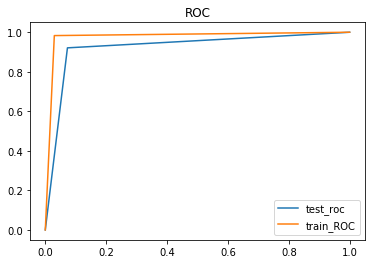

Probability density for train


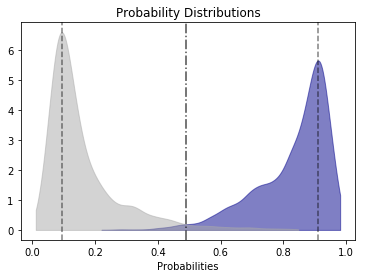

Probability density for test


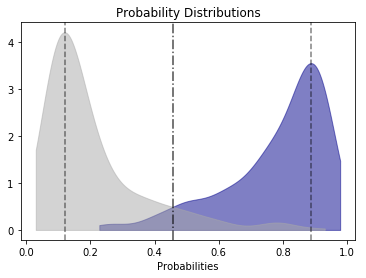


[[344  27]
 [ 27 315]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          344   27  371
1           27  315  342
All        371  342  713


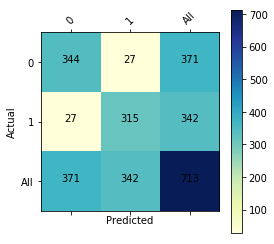

REPORT
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       371
          1       0.92      0.92      0.92       342

avg / total       0.92      0.92      0.92       713

ACCURACY 0.9242636746143057
-----------------

AUC_TRAIN =  0.9771013360851059

AUC =  0.9345692174050383


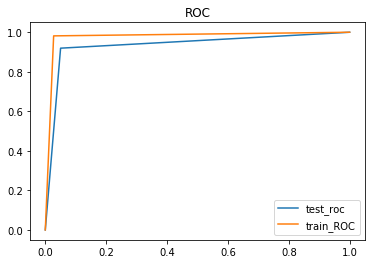

Probability density for train


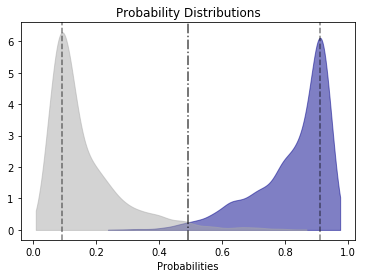

Probability density for test


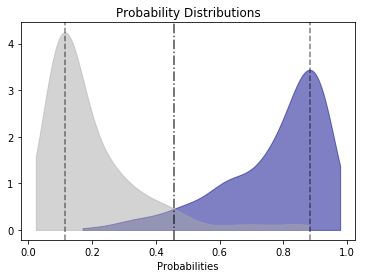


[[359  19]
 [ 27 308]]
CONFUSION MATRIX
Predicted    0    1  All
Actual                  
0          359   19  378
1           27  308  335
All        386  327  713


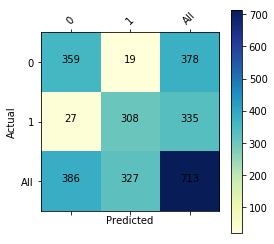

REPORT
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       378
          1       0.94      0.92      0.93       335

avg / total       0.94      0.94      0.94       713

ACCURACY 0.9354838709677419
-----------------


In [10]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    prediction_prob_train = rf_classifier_cv.predict_proba(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()
    
    print("Probability density for train")
    probability_density(prediction_prob_train[:, 1], y_train)
    print("Probability density for test")
    probability_density(prediction_prob[:, 1], y_test)
    
    print("")
    print(confusion_matrix(y_test, prediction_result))
    plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))
    
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")
